# Smart Device Human Activity Recognition (HAR) Model (Using Feature Engineering?)

[Eugene Zen](mailto:ezen@ucsd.edu), [Shane Luna](mailto:shluna@ucsd.edu)

## I. Summary
This notebook presents the development of a Human Activity Recognition (HAR) model that utilizes sensors from both smartphones and smartwatches. The data was originally collected and analyzed by the members of the WISDM (Wireless Sensor Data Mining) Lab in the Department of Computer and Information Science of Fordham University. More information on the original experiment can be found in the publication from 2019 [here](https://ieeexplore.ieee.org/document/8835065). The data was made publicly available on the UCI Machine Learning Repository as the "WISDM Smartphone and Smartwach Activity and Biometrics Dataset" and can be found [here](https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+).

## II. Development

### Dependencies

In [1]:
%matplotlib inline

from dask.distributed import Client
import dask.dataframe as dd
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd
import string

In [2]:
# Start local dask client
client = Client(n_workers=4)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:36855 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 4.82 GiB


### Load Data

In [4]:
def read_file(filepath):
    df = dd.read_csv(filepath, sep = ',', header = None)
#     unit = 'us' if 'phone' in filepath else 'ms' # phone in microseconds / watch in milliseconds
    df.columns = ['subject_id', 'activity_code', 'timestamp', 'x', 'y', 'z']
    df['timestamp_dt'] = dd.to_datetime(df['timestamp'], origin='unix')
    df['z'] = df['z'].str.replace(";","").astype('float64') # remove ; and ensure float (having issues with lineterminator)
    return df

In [5]:
# Phone Data
phone_accel_df = read_file('wisdm-dataset/raw/phone/accel/*.txt')
phone_gyro_df = read_file('wisdm-dataset/raw/phone/gyro/*.txt')

# Watch Data
watch_accel_df = read_file('wisdm-dataset/raw/watch/accel/*.txt')
watch_gyro_df = read_file('wisdm-dataset/raw/watch/gyro/*.txt')

In [6]:
# TEST: Datetime Converter us vs. ms
# pd.to_datetime((phone_accel_df['timestamp']).to_frame().head(5)['timestamp'], origin='unix', unit='us')
# pd.to_datetime((watch_accel_df['timestamp']).to_frame().head(5)['timestamp'], origin='unix', unit='ms')

Referring to the dataset description provided from the WISDM Lab, we expect to see the following row counts:

- raw/phone/accel: 4,804,403
- raw/phone/gyro: 3,608,635
- raw/watch/accel: 3,777,046
- raw/watch/gyro: 3,440,342

In [7]:
print(f'Phone Accel:\t{len(phone_accel_df)}')
print(f'Phone Gyro:\t{len(phone_gyro_df)}')
print(f'Watch Accel:\t{len(watch_accel_df)}')
print(f'Watch Gyro:\t{len(watch_gyro_df)}')

Phone Accel:	4804403
Phone Gyro:	3608635
Watch Accel:	3777046
Watch Gyro:	3440342


All of the above dataframes are stuctured the same. A sample output of the column datatypes has been provided below for reference. An additional column, timestamp_dt, was added to the original data by converting the timestamp attribute to a datetime object type. The original timestamp column has been preserved if needed for future enhancements.

In [8]:
print(phone_accel_df.dtypes)

subject_id                int64
activity_code            object
timestamp                 int64
x                       float64
y                       float64
z                       float64
timestamp_dt     datetime64[ns]
dtype: object


### Exploratory Data Analysis

In [9]:
# Check for nulls

print('--Phone Accel--')
print(phone_accel_df.isna().sum().compute())

print('--Phone Gyro--')
print(phone_gyro_df.isna().sum().compute())

print('--Watch Accel--')
print(watch_accel_df.isna().sum().compute())

print('--Watch Gyro--')
print(watch_gyro_df.isna().sum().compute())

--Phone Accel--
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
timestamp_dt     0
dtype: int64
--Phone Gyro--
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
timestamp_dt     0
dtype: int64
--Watch Accel--
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
timestamp_dt     0
dtype: int64
--Watch Gyro--
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
timestamp_dt     0
dtype: int64


In [10]:
def plot_subject_activity(df, title_append=None):
    subject_id = df.head(1)['subject_id'].item()
    activity_code = df.head(1)['activity_code'].item()
    title = f'Subject {subject_id} Performing Activity {activity_code}' 
    if title_append != None:
        title+=str(f' ({title_append})')
        
    fig, ax = plt.subplots(3, figsize=(20,5), sharex=True)
    fig.suptitle(title)
    ax[0].plot(range(len(df)), df['x'].to_numpy(), c='C0')
    ax[0].set_title('x')
    ax[1].plot(range(len(df)), df['y'].to_numpy(), c='C1')
    ax[1].set_title('y')
    ax[2].plot(range(len(df)), df['z'].to_numpy(), c='C2')
    ax[2].set_title('z')
    ax[2].set_xlabel('Interval')

Visualizations have been provided below of tri-axial sensor readings from both a smartphone accelerometer (first) and smarphone gyroscope (second). Our efforts aim to assess the distinctness of these patterns for different physical activities. 

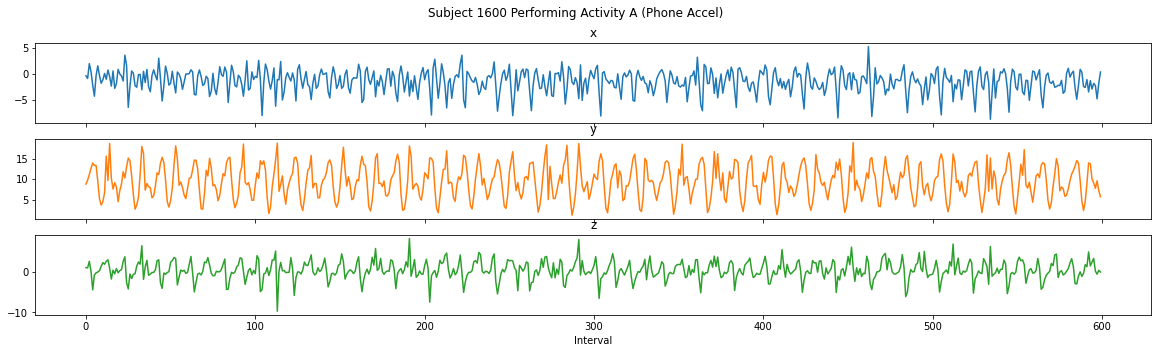

In [11]:
# Sample chart of a user performing an activity for 30 seconds or ~600 intervals @ 20Hz
# Activity A = Walking
activity = phone_accel_df[(phone_accel_df['subject_id'] == 1600) & (phone_accel_df['activity_code'] == "A")].compute()[0:600]
plot_subject_activity(activity, 'Phone Accel')

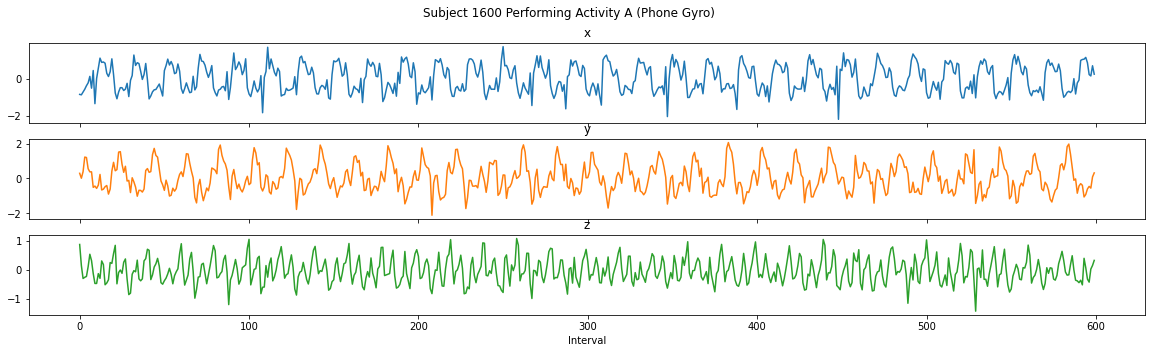

In [12]:
# Sample chart of a user performing an activity for 30 seconds or ~600 intervals @ 20Hz
# Activity A = Walking
activity = phone_gyro_df[(phone_gyro_df['subject_id'] == 1600) & (phone_gyro_df['activity_code'] == 'A')].compute()[0:600]
plot_subject_activity(activity, 'Phone Gyro')

In [13]:
subjects = phone_accel_df['subject_id'].unique().compute()
activities = phone_accel_df['activity_code'].unique().compute()

In [14]:
# Which sensors have missing activities

subject_activities_df = pd.DataFrame(subjects).merge(pd.DataFrame(activities), how='cross')

phone_accel_interval_counts = phone_accel_df.groupby(['subject_id', 'activity_code']).size().rename('phone_accel').reset_index().compute()
subject_activities_df = subject_activities_df.merge(phone_accel_interval_counts, on=['subject_id', 'activity_code'], how='left')

phone_gyro_interval_counts = phone_gyro_df.groupby(['subject_id', 'activity_code']).size().rename('phone_gyro').reset_index().compute()
subject_activities_df = subject_activities_df.merge(phone_gyro_interval_counts, on=['subject_id', 'activity_code'], how='left')

watch_accel_interval_counts = watch_accel_df.groupby(['subject_id', 'activity_code']).size().rename('watch_accel').reset_index().compute()
subject_activities_df = subject_activities_df.merge(watch_accel_interval_counts, on=['subject_id', 'activity_code'], how='left')

watch_gyro_interval_counts = watch_gyro_df.groupby(['subject_id', 'activity_code']).size().rename('watch_gyro').reset_index().compute()
subject_activities_df = subject_activities_df.merge(watch_gyro_interval_counts, on=['subject_id', 'activity_code'], how='left')

subject_activities_df = subject_activities_df.set_index(['subject_id'])

subject_activities_df.isna().sum()

activity_code     0
phone_accel       8
phone_gyro       10
watch_accel       6
watch_gyro       11
dtype: int64

In [15]:
subject_activities_df[subject_activities_df.isna().any(axis=1)]

,activity_code,phone_accel,phone_gyro,watch_accel,watch_gyro
subject_id,,,,,
1607,J,NaN,NaN,3603.0,3602.0
1609,B,NaN,NaN,3605.0,3603.0
1616,B,NaN,NaN,NaN,NaN
1616,F,NaN,NaN,3605.0,3603.0
1618,O,NaN,NaN,NaN,NaN
1637,C,3600.0,3598.0,8931.0,NaN
1637,J,3600.0,3598.0,NaN,NaN
1638,H,3615.0,3613.0,8931.0,NaN
1638,O,3601.0,3599.0,8936.0,NaN


Additional Takeaways:
- Not all subjects performed all activities
- Some subjects may have performed certain activites with limited sensors recording

### Data Preparation

Regarding data preparation, there will be two main tasks:
1. Join the sensor data for each device by timestamp.
2. Break each activity done by a subject into a desired window size (in seconds) to train/test on
    - Aggregate/engineer desired features for each window 

In the WISDM dataset description, it was noted that the data collection process was not perfect and that their actual number of recordings didn't match their expected number of recordings. For example, they are unsure why there are so many more sensor readings for the phone accelerometer. We are placing high trust in the data collection process done by the WISDM Lab team, but are aware that there could be anomalies with an imperfect process. For example, we have already seen above that there is missing activity data for certain subjects and device sensors. That being said, we are trusting that the timestamps among sensors were accurately synced.

Our go-forward approach is going to be to only use device data where it exists for both sensors.

- **to_use_phone_data** = inner join phone_accel and phone_gryo data on timestamp (keep only activites where both sensor data available)
- **to_use_watch_data** = inner join watch_accel and watch_gryo data on timestamp (keep only activites where both sensor data available)

When training a model based on both phone AND watch data, we will use only activity data available with all 4 sensors.

<H2>Eugene experimental code section</H2>

In [16]:
#Run the group by strictly on the phone_gyro data

In [17]:
phone_gyro_grouped_df = phone_gyro_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

In [ ]:
phone_gyro_grouped_interval_counts = phone_gyro_grouped_df.count()
phone_gyro_grouped_interval_counts.head()

In [ ]:
phone_gyro_grouped_interval_counts[phone_gyro_grouped_interval_counts['x'] < 59].compute()

In [ ]:
phone_gyro_grouped_interval_counts[phone_gyro_grouped_interval_counts['x'] > 60].compute()

In [ ]:
# phone_gyro_grouped_interval_counts['x'].max().compute()
phone_gyro_grouped_interval_counts.nlargest(100, "x").compute()

In [18]:
# phone_gyro_grouped_mean_df = phone_gyro_grouped_df.mean()
# phone_gyro_grouped_mean_df.head()

phone_gyro_grouped_mean_df = phone_gyro_grouped_df.agg(['mean', 'std']).fillna(0)
phone_gyro_grouped_mean_df.columns = phone_gyro_grouped_mean_df.columns.map('_'.join)
phone_gyro_grouped_mean_df.head()

timestamp_mean  timestamp_std  \
subject_id activity_code timestamp_dt                                         
1603       A             1970-01-01 02:21:24    8.485868e+12   8.594088e+08   
                         1970-01-01 02:21:27    8.488502e+12   9.483714e+08   
                         1970-01-01 02:21:30    8.491495e+12   0.000000e+00   
                         1970-01-01 02:21:33    8.494488e+12   0.000000e+00   
                         1970-01-01 02:21:36    8.497501e+12   8.063148e+08   

                                                x_mean     x_std    y_mean  \
subject_id activity_code timestamp_dt                                        
1603       A             1970-01-01 02:21:24  0.130771  1.560820 -0.017194   
                         1970-01-01 02:21:27  0.071575  2.068814  0.010915   
                         1970-01-01 02:21:30  0.025613  1.859737 -0.055671   
                         1970-01-01 02:21:33 -0.092753  1.601559  0.044169   
                         1970-01-01 02:21:36 -0.026278  1.689287  0.007075   

                                                 y_std    z_mean     z_std  
subject_id activity_code timestamp_dt                                       
1603       A             1970-01-01 02:21:24  2.013496 -0.391190  1.040595  
                         1970-01-01 02:21:27  2.393875  0.114605  0.859421  
                         1970-01-01 02:21:30  2.357789  0.142522  0.851089  
                         1970-01-01 02:21:33  1.982819  0.132888  0.740964  
                         1970-01-01 02:21:36  1.831074  0.135310  0.654597

In [ ]:
# phone_gyro_grouped_mean_df2 = phone_gyro_grouped_df.agg(['mean', 'std'])
# phone_gyro_grouped_mean_df2.columns = phone_gyro_grouped_mean_df2.columns.map('_'.join)
# phone_gyro_grouped_mean_df2.head()

In [ ]:
# phone_gyro_grouped_mean_df['seq'] = phone_gyro_grouped_mean_df.groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')]).cumcount()
# phone_gyro_grouped_mean_df.head()

In [ ]:
#Run the group by strictly on the phone_accel data

In [19]:
phone_accel_grouped_df = phone_accel_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

In [ ]:
phone_accel_grouped_interval_counts = phone_accel_grouped_df.count()
phone_accel_grouped_interval_counts.head()

In [ ]:
phone_accel_grouped_interval_counts[phone_accel_grouped_interval_counts['x'] < 59].compute()

In [20]:
# phone_accel_grouped_mean_df = phone_accel_grouped_df.mean()
# phone_accel_grouped_mean_df.head()

phone_accel_grouped_mean_df = phone_accel_grouped_df.agg(['mean', 'std']).fillna(0)
phone_accel_grouped_mean_df.columns = phone_accel_grouped_mean_df.columns.map('_'.join)
phone_accel_grouped_mean_df.head()

timestamp_mean  timestamp_std  \
subject_id activity_code timestamp_dt                                         
1603       A             1970-01-01 02:21:24    8.485868e+12   8.594088e+08   
                         1970-01-01 02:21:27    8.488502e+12   9.483714e+08   
                         1970-01-01 02:21:30    8.491495e+12   0.000000e+00   
                         1970-01-01 02:21:33    8.494488e+12   0.000000e+00   
                         1970-01-01 02:21:36    8.497501e+12   8.063148e+08   

                                                x_mean     x_std    y_mean  \
subject_id activity_code timestamp_dt                                        
1603       A             1970-01-01 02:21:24  4.212986  4.628513  7.737745   
                         1970-01-01 02:21:27  0.559605  3.657154  9.691457   
                         1970-01-01 02:21:30  0.714135  3.981727  9.918300   
                         1970-01-01 02:21:33  0.726632  3.442589  9.816738   
                         1970-01-01 02:21:36  1.110398  3.747706  9.851376   

                                                 y_std    z_mean     z_std  
subject_id activity_code timestamp_dt                                       
1603       A             1970-01-01 02:21:24  4.933155  0.392429  4.481095  
                         1970-01-01 02:21:27  4.949684  0.405618  5.473689  
                         1970-01-01 02:21:30  4.833489 -0.132423  4.686573  
                         1970-01-01 02:21:33  4.236077  0.360471  4.312902  
                         1970-01-01 02:21:36  4.240831  0.614979  4.083812

In [21]:
phone_gyro_grouped_mean_df = phone_gyro_grouped_mean_df.reset_index()
phone_accel_grouped_mean_df = phone_accel_grouped_mean_df.reset_index()

In [22]:
phone_gyro_grouped_mean_df.head()

,subject_id,activity_code,timestamp_dt,timestamp_mean,timestamp_std,x_mean,x_std,y_mean,y_std,z_mean,z_std
0,1603,A,1970-01-01 02:21:24,8.485868e+12,8.594088e+08,0.130771,1.560820,-0.017194,2.013496,-0.391190,1.040595
1,1603,A,1970-01-01 02:21:27,8.488502e+12,9.483714e+08,0.071575,2.068814,0.010915,2.393875,0.114605,0.859421
2,1603,A,1970-01-01 02:21:30,8.491495e+12,0.000000e+00,0.025613,1.859737,-0.055671,2.357789,0.142522,0.851089
3,1603,A,1970-01-01 02:21:33,8.494488e+12,0.000000e+00,-0.092753,1.601559,0.044169,1.982819,0.132888,0.740964
4,1603,A,1970-01-01 02:21:36,8.497501e+12,8.063148e+08,-0.026278,1.689287,0.007075,1.831074,0.135310,0.654597


In [23]:
phone_accel_grouped_mean_df.head()

,subject_id,activity_code,timestamp_dt,timestamp_mean,timestamp_std,x_mean,x_std,y_mean,y_std,z_mean,z_std
0,1603,A,1970-01-01 02:21:24,8.485868e+12,8.594088e+08,4.212986,4.628513,7.737745,4.933155,0.392429,4.481095
1,1603,A,1970-01-01 02:21:27,8.488502e+12,9.483714e+08,0.559605,3.657154,9.691457,4.949684,0.405618,5.473689
2,1603,A,1970-01-01 02:21:30,8.491495e+12,0.000000e+00,0.714135,3.981727,9.918300,4.833489,-0.132423,4.686573
3,1603,A,1970-01-01 02:21:33,8.494488e+12,0.000000e+00,0.726632,3.442589,9.816738,4.236077,0.360471,4.312902
4,1603,A,1970-01-01 02:21:36,8.497501e+12,8.063148e+08,1.110398,3.747706,9.851376,4.240831,0.614979,4.083812


In [24]:
phone_grouped_means_df = phone_accel_grouped_mean_df.merge(phone_gyro_grouped_mean_df, on=["subject_id", "activity_code", "timestamp_dt"], how="inner", suffixes=['_accel', '_gyro'])
# phone_grouped_means_df = phone_grouped_means_df.drop(['timestamp_gyro'], axis=1)
# phone_grouped_means_df = phone_grouped_means_df.rename(columns={'timestamp_accel': 'timestamp'})
phone_grouped_means_df.head()

,subject_id,activity_code,timestamp_dt,timestamp_mean_accel,timestamp_std_accel,x_mean_accel,x_std_accel,y_mean_accel,y_std_accel,z_mean_accel,z_std_accel,timestamp_mean_gyro,timestamp_std_gyro,x_mean_gyro,x_std_gyro,y_mean_gyro,y_std_gyro,z_mean_gyro,z_std_gyro
0,1603,A,1970-01-01 02:21:24,8.485868e+12,8.594088e+08,4.212986,4.628513,7.737745,4.933155,0.392429,4.481095,8.485868e+12,8.594088e+08,0.130771,1.560820,-0.017194,2.013496,-0.391190,1.040595
1,1603,A,1970-01-01 02:21:27,8.488502e+12,9.483714e+08,0.559605,3.657154,9.691457,4.949684,0.405618,5.473689,8.488502e+12,9.483714e+08,0.071575,2.068814,0.010915,2.393875,0.114605,0.859421
2,1603,A,1970-01-01 02:21:30,8.491495e+12,0.000000e+00,0.714135,3.981727,9.918300,4.833489,-0.132423,4.686573,8.491495e+12,0.000000e+00,0.025613,1.859737,-0.055671,2.357789,0.142522,0.851089
3,1603,A,1970-01-01 02:21:33,8.494488e+12,0.000000e+00,0.726632,3.442589,9.816738,4.236077,0.360471,4.312902,8.494488e+12,0.000000e+00,-0.092753,1.601559,0.044169,1.982819,0.132888,0.740964
4,1603,A,1970-01-01 02:21:36,8.497501e+12,8.063148e+08,1.110398,3.747706,9.851376,4.240831,0.614979,4.083812,8.497501e+12,8.063148e+08,-0.026278,1.689287,0.007075,1.831074,0.135310,0.654597


In [25]:
len(phone_grouped_means_df)

55249

In [ ]:
#Run the group by strictly on the watch_gyro data

In [26]:
watch_gyro_grouped_df = watch_gyro_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

In [ ]:
watch_gyro_grouped_interval_counts = watch_gyro_grouped_df.count()
watch_gyro_grouped_interval_counts.head()

In [ ]:
watch_gyro_grouped_interval_counts[watch_gyro_grouped_interval_counts['x'] < 59].compute()

In [ ]:
watch_gyro_grouped_interval_counts[watch_gyro_grouped_interval_counts['x'] > 60].compute()

In [ ]:
# watch_gyro_grouped_interval_counts['x'].max().compute()
watch_gyro_grouped_interval_counts.nlargest(100, "x").compute()

In [27]:
# watch_gyro_grouped_mean_df = watch_gyro_grouped_df.mean()
# watch_gyro_grouped_mean_df.head()

watch_gyro_grouped_mean_df = watch_gyro_grouped_df.agg(['mean', 'std']).fillna(0)
watch_gyro_grouped_mean_df.columns = watch_gyro_grouped_mean_df.columns.map('_'.join)
watch_gyro_grouped_mean_df.head()

timestamp_mean  timestamp_std  \
subject_id activity_code timestamp_dt                                         
1603       A             1970-01-01 02:16:48    8.209871e+12   1.057419e+09   
                         1970-01-01 02:16:51    8.212519e+12   0.000000e+00   
                         1970-01-01 02:16:54    8.215517e+12   1.184152e+09   
                         1970-01-01 02:16:57    8.218515e+12   0.000000e+00   
                         1970-01-01 02:17:00    8.221513e+12   6.660055e+08   

                                                x_mean     x_std    y_mean  \
subject_id activity_code timestamp_dt                                        
1603       A             1970-01-01 02:16:48  0.258547  1.800947  0.293847   
                         1970-01-01 02:16:51  0.073079  1.785556  0.028109   
                         1970-01-01 02:16:54  0.111219  2.267612  0.203831   
                         1970-01-01 02:16:57  0.225818  2.417827  0.268076   
                         1970-01-01 02:17:00  0.039034  1.675469  0.181341   

                                                 y_std    z_mean     z_std  
subject_id activity_code timestamp_dt                                       
1603       A             1970-01-01 02:16:48  1.139514  0.172260  2.148195  
                         1970-01-01 02:16:51  1.960544  0.147318  2.951272  
                         1970-01-01 02:16:54  2.046423 -0.018047  3.034343  
                         1970-01-01 02:16:57  1.870087 -0.090841  2.640429  
                         1970-01-01 02:17:00  1.457610 -0.105169  2.516248

In [ ]:
#Run the group by strictly on the watch_accel data

In [28]:
watch_accel_grouped_df = watch_accel_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

In [ ]:
watch_accel_grouped_interval_counts = watch_accel_grouped_df.count()
watch_accel_grouped_interval_counts.head()

In [ ]:
watch_accel_grouped_interval_counts[watch_accel_grouped_interval_counts['x'] < 59].compute()

In [ ]:
watch_accel_grouped_interval_counts[watch_accel_grouped_interval_counts['x'] > 60].compute()

In [ ]:
# watch_accel_grouped_interval_counts['x'].max().compute()
watch_accel_grouped_interval_counts.nlargest(100, "x").compute()

In [29]:
# watch_accel_grouped_mean_df = watch_accel_grouped_df.mean()
# watch_accel_grouped_mean_df.head()

watch_accel_grouped_mean_df = watch_accel_grouped_df.agg(['mean', 'std']).fillna(0)
watch_accel_grouped_mean_df.columns = watch_accel_grouped_mean_df.columns.map('_'.join)
watch_accel_grouped_mean_df.head()

timestamp_mean  timestamp_std  \
subject_id activity_code timestamp_dt                                         
1603       A             1970-01-01 02:16:48    8.209871e+12   1.057419e+09   
                         1970-01-01 02:16:51    8.212519e+12   0.000000e+00   
                         1970-01-01 02:16:54    8.215517e+12   1.184152e+09   
                         1970-01-01 02:16:57    8.218515e+12   0.000000e+00   
                         1970-01-01 02:17:00    8.221513e+12   6.660055e+08   

                                                 x_mean     x_std    y_mean  \
subject_id activity_code timestamp_dt                                         
1603       A             1970-01-01 02:16:48  10.971969  2.463573 -1.710755   
                         1970-01-01 02:16:51  13.317089  3.006993 -1.427652   
                         1970-01-01 02:16:54  13.485122  2.963782 -1.719705   
                         1970-01-01 02:16:57  12.623339  2.569088 -1.817349   
                         1970-01-01 02:17:00  11.856955  1.774415 -1.782553   

                                                 y_std    z_mean     z_std  
subject_id activity_code timestamp_dt                                       
1603       A             1970-01-01 02:16:48  3.081793 -2.138438  2.455856  
                         1970-01-01 02:16:51  3.426723 -1.287362  2.940808  
                         1970-01-01 02:16:54  3.342998 -1.938705  2.519909  
                         1970-01-01 02:16:57  2.517277 -2.037466  2.532273  
                         1970-01-01 02:17:00  2.348758 -1.714807  1.618585

In [30]:
watch_gyro_grouped_mean_df = watch_gyro_grouped_mean_df.reset_index()
watch_accel_grouped_mean_df = watch_accel_grouped_mean_df.reset_index()

In [31]:
watch_gyro_grouped_mean_df.head()

,subject_id,activity_code,timestamp_dt,timestamp_mean,timestamp_std,x_mean,x_std,y_mean,y_std,z_mean,z_std
0,1603,A,1970-01-01 02:16:48,8.209871e+12,1.057419e+09,0.258547,1.800947,0.293847,1.139514,0.172260,2.148195
1,1603,A,1970-01-01 02:16:51,8.212519e+12,0.000000e+00,0.073079,1.785556,0.028109,1.960544,0.147318,2.951272
2,1603,A,1970-01-01 02:16:54,8.215517e+12,1.184152e+09,0.111219,2.267612,0.203831,2.046423,-0.018047,3.034343
3,1603,A,1970-01-01 02:16:57,8.218515e+12,0.000000e+00,0.225818,2.417827,0.268076,1.870087,-0.090841,2.640429
4,1603,A,1970-01-01 02:17:00,8.221513e+12,6.660055e+08,0.039034,1.675469,0.181341,1.457610,-0.105169,2.516248


In [32]:
watch_accel_grouped_mean_df.head()

,subject_id,activity_code,timestamp_dt,timestamp_mean,timestamp_std,x_mean,x_std,y_mean,y_std,z_mean,z_std
0,1603,A,1970-01-01 02:16:48,8.209871e+12,1.057419e+09,10.971969,2.463573,-1.710755,3.081793,-2.138438,2.455856
1,1603,A,1970-01-01 02:16:51,8.212519e+12,0.000000e+00,13.317089,3.006993,-1.427652,3.426723,-1.287362,2.940808
2,1603,A,1970-01-01 02:16:54,8.215517e+12,1.184152e+09,13.485122,2.963782,-1.719705,3.342998,-1.938705,2.519909
3,1603,A,1970-01-01 02:16:57,8.218515e+12,0.000000e+00,12.623339,2.569088,-1.817349,2.517277,-2.037466,2.532273
4,1603,A,1970-01-01 02:17:00,8.221513e+12,6.660055e+08,11.856955,1.774415,-1.782553,2.348758,-1.714807,1.618585


In [33]:
watch_grouped_means_df = watch_accel_grouped_mean_df.merge(watch_gyro_grouped_mean_df, on=["subject_id", "activity_code", "timestamp_dt"], how="inner", suffixes=['_accel', '_gyro'])
# watch_grouped_means_df = watch_grouped_means_df.drop(['timestamp_gyro'], axis=1)
# watch_grouped_means_df = watch_grouped_means_df.rename(columns={'timestamp_accel': 'timestamp'})
watch_grouped_means_df.head()

,subject_id,activity_code,timestamp_dt,timestamp_mean_accel,timestamp_std_accel,x_mean_accel,x_std_accel,y_mean_accel,y_std_accel,z_mean_accel,z_std_accel,timestamp_mean_gyro,timestamp_std_gyro,x_mean_gyro,x_std_gyro,y_mean_gyro,y_std_gyro,z_mean_gyro,z_std_gyro
0,1603,A,1970-01-01 02:16:48,8.209871e+12,1.057419e+09,10.971969,2.463573,-1.710755,3.081793,-2.138438,2.455856,8.209871e+12,1.057419e+09,0.258547,1.800947,0.293847,1.139514,0.172260,2.148195
1,1603,A,1970-01-01 02:16:51,8.212519e+12,0.000000e+00,13.317089,3.006993,-1.427652,3.426723,-1.287362,2.940808,8.212519e+12,0.000000e+00,0.073079,1.785556,0.028109,1.960544,0.147318,2.951272
2,1603,A,1970-01-01 02:16:54,8.215517e+12,1.184152e+09,13.485122,2.963782,-1.719705,3.342998,-1.938705,2.519909,8.215517e+12,1.184152e+09,0.111219,2.267612,0.203831,2.046423,-0.018047,3.034343
3,1603,A,1970-01-01 02:16:57,8.218515e+12,0.000000e+00,12.623339,2.569088,-1.817349,2.517277,-2.037466,2.532273,8.218515e+12,0.000000e+00,0.225818,2.417827,0.268076,1.870087,-0.090841,2.640429
4,1603,A,1970-01-01 02:17:00,8.221513e+12,6.660055e+08,11.856955,1.774415,-1.782553,2.348758,-1.714807,1.618585,8.221513e+12,6.660055e+08,0.039034,1.675469,0.181341,1.457610,-0.105169,2.516248


In [34]:
len(watch_grouped_means_df)

55273

In [ ]:
# combined_device_means_df = watch_grouped_means_df.merge(phone_grouped_means_df, on=['subject_id', 'activity_code', 'timestamp_dt'], how="inner", suffixes=['_watch', '_phone'])
# combined_device_means_df.head()

In [35]:
phone_grouped_clean_df = phone_grouped_means_df
watch_grouped_clean_df = watch_grouped_means_df

<h2>NOTE: NO RUN ZONE. DO NOT RUN ANYTHING BELOW UNTIL SECTION 2</h2>

In [ ]:
# Phone
phone_combined_df = phone_accel_df.merge(phone_gyro_df, on=['subject_id', 'activity_code', 'timestamp_dt'], how='inner', suffixes=['_accel', '_gyro'])
phone_combined_df = phone_combined_df.drop(['timestamp_gyro'], axis=1)
phone_combined_df = phone_combined_df.rename(columns={'timestamp_accel': 'timestamp'})
phone_combined_df.head()

In [ ]:
# Watch
watch_combined_df = watch_accel_df.merge(watch_gyro_df, on=['subject_id', 'activity_code', 'timestamp_dt'], how='inner', suffixes=['_accel', '_gyro'])
watch_combined_df = watch_combined_df.drop(['timestamp_gyro'], axis=1)
watch_combined_df = watch_combined_df.rename(columns={'timestamp_accel': 'timestamp'})
watch_combined_df.head()

In [ ]:
# Phone & Watch
# phone_watch_combined_df = phone_combined_df.merge(watch_combined_df, on=['subject_id', 'activity_code', 'timestamp_dt'], how='inner', suffixes=['_phone', '_watch'])
# phone_watch_combined_df.head()
# phone and watch data do not have times synced -- currently unable to use together

In [ ]:
print(f'Phone: {len(phone_combined_df)}')
print(f'Watch: {len(watch_combined_df)}')

In [ ]:
corr_matrix_phone = phone_combined_df.corr()
corr_matrix_phone.compute().style.background_gradient(cmap='coolwarm')

In [ ]:
corr_matrix_watch = watch_combined_df.corr()
corr_matrix_watch.compute().style.background_gradient(cmap='coolwarm')

In [ ]:
phone_grouped_df = phone_combined_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])
watch_grouped_df = watch_combined_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

In [ ]:
# Timestamp grouping/interval count check
# size = phone_grouped_df.size().rename('count').to_frame()
# size.compute().value_counts().head(50)

In [ ]:
# pd.Grouper check (to understand if it keeps the first or last of the interval)
# https://stackoverflow.com/questions/35898667/group-by-time-and-other-column-in-pandas
# sample_df = phone_accel_df.head(60)
# sample_group_df = sample_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

# print(sample_df.head())
# sample_group_df.agg(['mean', 'count'])

# Findings:
# groups by looking at whole second intervals
# shows timestamp for first time in interval

In [ ]:
phone_grouped_means_df = phone_grouped_df.mean().reset_index()
phone_grouped_counts_df = phone_grouped_df.size().rename('count').reset_index()
phone_grouped_means_df = phone_grouped_means_df.merge(phone_grouped_counts_df, on=['subject_id', 'activity_code', 'timestamp_dt'])
print(f'Phone full: {len(phone_grouped_means_df)}')

phone_grouped_clean_df = phone_grouped_means_df[phone_grouped_means_df['count'] > 20]
print(f'Phone > 20: {len(phone_grouped_clean_df)}')

watch_grouped_means_df = watch_grouped_df.mean().reset_index()
watch_grouped_counts_df = watch_grouped_df.size().rename('count').reset_index()
watch_grouped_means_df = watch_grouped_means_df.merge(watch_grouped_counts_df, on=['subject_id', 'activity_code', 'timestamp_dt'])
print(f'Watch full: {len(watch_grouped_means_df)}')

watch_grouped_clean_df = watch_grouped_means_df[watch_grouped_means_df['count'] > 20]
print(f'Watch > 20: {len(watch_grouped_clean_df)}')

In [ ]:
phone = phone_grouped_clean_df['activity_code'].value_counts().rename('total').reset_index().compute().sort_values(by=['index'], ascending=True)
watch = watch_grouped_clean_df['activity_code'].value_counts().rename('total').reset_index().compute().sort_values(by=['index'], ascending=True)

In [ ]:
total = phone['total'].sum()

plt.figure(figsize=(10,5))

plt.plot(phone['index'], (phone['total']/total*100), label='phone')
plt.plot(watch['index'], (watch['total']/total*100), label='watch')

plt.title('Data Distribution by Activity Code')
plt.xlabel('Activity Code')
plt.ylabel('% of Respective Dataset')
plt.legend()
plt.show()

<h2>END OF NO RUN ZONE</h2>

# 2. Model Selection & Training

In [36]:
# train test split with 80-20 split
import dask_ml.model_selection

data_columns = ['x_mean_accel', 'y_mean_accel', 'z_mean_accel', 'x_mean_gyro', 'y_mean_gyro', 'z_mean_gyro', 'x_std_accel', 'y_std_accel', 'z_std_accel', 'x_std_gyro', 'y_std_gyro', 'z_std_gyro']
label_columns = ['activity_code']

# drop subject and timestamps from train data
phone_data_all = phone_grouped_clean_df[data_columns]
phone_labels_all = phone_grouped_clean_df[label_columns]

# drop subject and timestamps from train data
watch_data_all = watch_grouped_clean_df[data_columns]
watch_labels_all = watch_grouped_clean_df[label_columns]

X_train_phone, X_test_phone, y_train_phone, y_test_phone = dask_ml.model_selection.train_test_split(phone_data_all, phone_labels_all, shuffle = True, random_state=0, test_size = 0.2)
X_train_watch, X_test_watch, y_train_watch, y_test_watch = dask_ml.model_selection.train_test_split(watch_data_all, watch_labels_all, shuffle = True, random_state=0, test_size = 0.2)

In [37]:
print(f'X_train_phone: {len(X_train_phone)}')
print(f'X_test_phone: {len(X_test_phone)}')
print(f'y_train_phone: {len(y_train_phone)}')
print(f'y_test_phone: {len(y_test_phone)}')

X_train_phone: 44119
X_test_phone: 11130
y_train_phone: 44119
y_test_phone: 11130


In [ ]:
print(f'X_train_watch: {len(X_train_watch)}')
print(f'X_test_watch: {len(X_test_watch)}')
print(f'y_train_watch: {len(y_train_watch)}')
print(f'y_test_watch: {len(y_test_watch)}')

In [ ]:
X_train_phone.head()

In [ ]:
X_test_phone.head()

In [ ]:
y_train_phone.head()

In [ ]:
y_test_phone.head()

In [38]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_phone = RandomForestClassifier(random_state=0)

with joblib.parallel_backend('dask'):
    clf_phone.fit(X_train_phone, y_train_phone)

<timed exec>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 12.6 s, sys: 2.52 s, total: 15.1 s
Wall time: 1min 5s


In [66]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_watch = RandomForestClassifier(random_state=0)

with joblib.parallel_backend('dask'):
    clf_watch.fit(X_train_watch, y_train_watch)

<timed exec>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 20.7 s, sys: 4.61 s, total: 25.3 s
Wall time: 1min 31s


# 3. Model Test

In [ ]:
# test /validate and provide final accurracy
# with joblib.parallel_backend('dask'):
#     score = randomForestClassifier.score(X_test_reset, X_test_labels)
# score

In [ ]:
# from sklearn.metrics import confusion_matrix
# with joblib.parallel_backend('dask'):
#     confusion_matrix(X_test_labels, randomForestClassifier.predict(X_test_reset) )

In [39]:
%%time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

with joblib.parallel_backend('dask'):
    predicted_labels_phone = clf_phone.predict(X_test_phone)

CPU times: user 6 s, sys: 1.02 s, total: 7.01 s
Wall time: 26.4 s


In [67]:
%%time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

with joblib.parallel_backend('dask'):
    predicted_labels_watch = clf_watch.predict(X_test_watch)

CPU times: user 9.18 s, sys: 1.67 s, total: 10.8 s
Wall time: 36.1 s


In [40]:
%%time

with joblib.parallel_backend('dask'):
    print(accuracy_score(y_test_phone, predicted_labels_phone))

0.8375561545372866
CPU times: user 38.8 s, sys: 7.37 s, total: 46.1 s
Wall time: 2min 43s


In [68]:
%%time

with joblib.parallel_backend('dask'):
    print(accuracy_score(y_test_watch, predicted_labels_watch))

0.7886653493802767
CPU times: user 12.4 s, sys: 1.81 s, total: 14.2 s
Wall time: 58.9 s


In [41]:
unique_phone_labels = np.unique(y_test_phone)
unique_phone_labels

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'O', 'P', 'Q', 'R', 'S'], dtype=object)

In [69]:
unique_watch_labels = np.unique(y_test_watch)
unique_watch_labels

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'O', 'P', 'Q', 'R', 'S'], dtype=object)

In [42]:
%%time
cm_phone = confusion_matrix(y_test_phone, predicted_labels_phone, labels = unique_phone_labels)
cm_phone

CPU times: user 19.9 s, sys: 3.4 s, total: 23.3 s
Wall time: 1min 34s


array([[606,   1,  25,   0,   0,   0,   0,   0,   0,   0,   1,   0,  15,
          1,   3,   0,   1,   0],
       [  2, 593,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          2,   1,   0,   0,   0],
       [ 10,   4, 573,   0,   0,   0,   0,   0,   0,   0,   0,   0,  23,
          4,   2,   0,   0,   0],
       [  1,   0,   7, 481,   4,   9,   7,   7,  17,   9,  10,   5,   3,
          2,   7,   6,  10,  10],
       [  0,   0,   1,   0, 540,   3,   2,   3,   2,   1,   1,   4,   7,
         13,  11,   0,   1,  45],
       [  1,   0,   1,   9,   6, 488,   6,   6,   4,   3,   7,   6,   0,
          2,   3,   4,   4,   6],
       [  0,   0,   1,   2,  10,   1, 550,   2,  16,   5,   5,   6,   3,
          6,   4,   2,   8,  14],
       [  0,   0,   2,  15,   9,   7,   7, 500,  10,  25,  12,  14,   3,
          3,  11,   2,   8,  14],
       [  0,   0,   3,   7,  10,   9,  16,  17, 469,  11,  17,  16,   2,
          0,   2,   2,  11,   9],
       [  0,   0,   1,   7,  15,   5,

<AxesSubplot:>

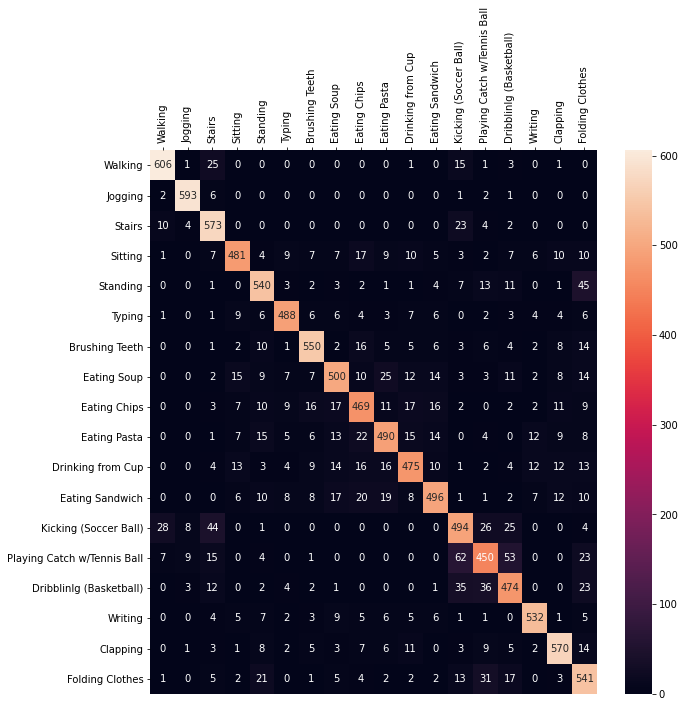

In [63]:
import matplotlib.pyplot as plt
display_labels = ["Walking", "Jogging", "Stairs", "Sitting", "Standing", "Typing", "Brushing Teeth", "Eating Soup", "Eating Chips", "Eating Pasta", "Drinking from Cup", "Eating Sandwich", "Kicking (Soccer Ball)", "Playing Catch w/Tennis Ball", "Dribblinlg (Basketball)", "Writing", "Clapping", "Folding Clothes"]

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
sns.heatmap(cm_phone, annot=True, fmt='g', xticklabels = display_labels, yticklabels = display_labels)

In [70]:
%%time
cm_watch = confusion_matrix(y_test_watch, predicted_labels_watch, labels = unique_watch_labels)
cm_watch

CPU times: user 15.5 s, sys: 1.85 s, total: 17.3 s
Wall time: 1min 11s


array([[500,   0,  36,   1,   1,   0,   1,   2,   3,   0,   0,   0,  36,
         13,   0,   0,   2,  29],
       [  0, 578,   1,   0,   0,   0,   0,   1,   1,   1,   0,   0,   1,
         12,   2,   0,   0,   8],
       [ 49,   4, 415,   1,   0,   0,   4,   2,   8,   4,   0,   1,  50,
         11,   3,   0,   2,  45],
       [  0,   0,   0, 458,   5,  23,   3,  10,  15,  27,  10,  12,   1,
          4,   1,  14,   4,  21],
       [  0,   0,   8,  11, 480,   4,   6,   3,   8,   5,   6,  11,  13,
          0,   6,   3,   2,  20],
       [  0,   0,   3,  18,   0, 587,   0,   2,   7,   7,   2,   4,   0,
          0,   0,  19,   2,   2],
       [  0,   0,   0,   0,   7,   1, 561,   3,  10,   5,   3,  12,   2,
          0,   0,   0,  15,   5],
       [  0,   0,   0,   4,   7,   0,   4, 452,  12,  62,  16,  17,   0,
          0,   0,  13,   1,  16],
       [  0,   0,   1,  19,   8,  22,  20,  29, 348,  47,  37,  64,   4,
          1,   0,   7,   0,  23],
       [  0,   0,   1,   5,   5,  10,

<AxesSubplot:>

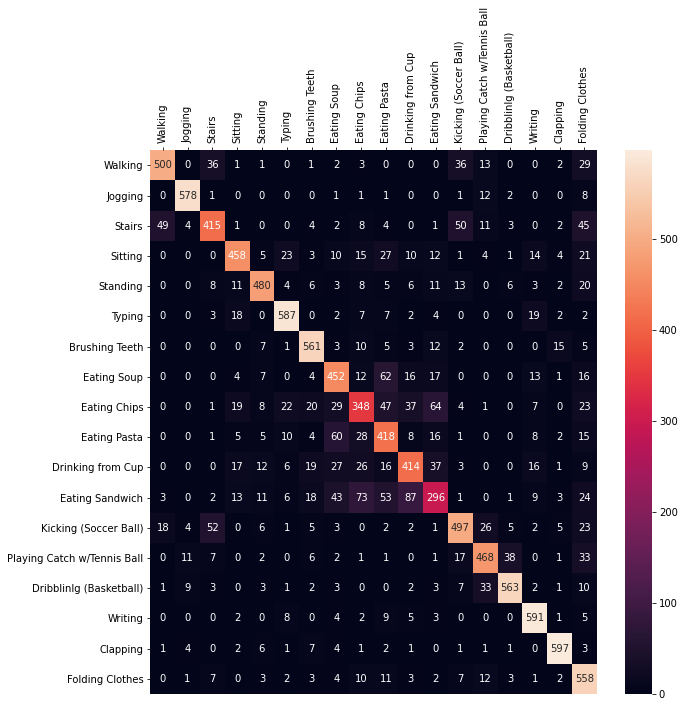

In [71]:
import matplotlib.pyplot as plt
display_labels = ["Walking", "Jogging", "Stairs", "Sitting", "Standing", "Typing", "Brushing Teeth", "Eating Soup", "Eating Chips", "Eating Pasta", "Drinking from Cup", "Eating Sandwich", "Kicking (Soccer Ball)", "Playing Catch w/Tennis Ball", "Dribblinlg (Basketball)", "Writing", "Clapping", "Folding Clothes"]

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
sns.heatmap(cm_watch, annot=True, fmt='g', xticklabels = display_labels, yticklabels = display_labels)

# 4. Results & Conclusion

In [ ]:
client.shutdown()